<a href="https://colab.research.google.com/github/ejlee127/sound-learning/blob/main/train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-11-14 00:19:04--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.07MB/s    in 0.2s    

2020-11-14 00:19:04 (5.07 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



UrbanSound Machine Learning: Experiment 3


*   Inputs: MFCCs statistical values


> input tables : fold1_mfcc_stat_n_180.csv  ~  fold10_mfcc_stat_n_180.csv

> mfcc : MFCC feature

> stat : scipy.stats.describe values -- min, max, mean, var, skewedness, kurtosis

> n_180 : each sample is an array of length 180

*   Model : keras-Sequential

> we run through many parameters, defined below



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [4]:
import numpy as np
import pandas as pd
import json

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
# Define functions

# create_train_test_val_set():
#   returns train set of [X, y], test set of [X, y] and val set of [X, y]
#   tables : list of mfcc_avg_n_40 tables
#   test_index : 
#   val_index :
def create_train_test_val_set(tables, test_index, val_index):

  #train_list = [ i for i in range(1,NUMFOLDS+1) if i not in TESTFOLD ]
  train_df = pd.DataFrame({})
  test_df = pd.DataFrame({})
  val_df = pd.DataFrame({})

  for i in range(1,NUMFOLDS+1):
    # load the table of fold{i}
    df_pandas = tables[i-1].toPandas()

    if i in test_index:      
      test_df = pd.concat( [test_df, df_pandas] )
    elif i in val_index:
      val_df = pd.concat( [val_df, df_pandas] )
    else:
      train_df = pd.concat( [train_df, df_pandas] )
    #print(i, train_df.shape)

  X_train = train_df.drop(['_c0', 'slice_fn', 'classID'], axis = 1)
  y_train = train_df['classID']
  train_Xy = [X_train.astype('float32'), y_train.astype('int')]
  print("X_train shape:", X_train.shape)

  X_test = test_df.drop(['_c0', 'slice_fn', 'classID'], axis = 1)
  y_test = test_df['classID']
  test_Xy = [X_test.astype('float32'), y_test.astype('int')]
  print("X_test shape:", X_test.shape)

  X_val = val_df.drop(['_c0', 'slice_fn', 'classID'], axis = 1)
  y_val = val_df['classID']
  val_Xy = [X_val.astype('float32'), y_val.astype('int')]
  print("X_val shape:", X_val.shape)

  return train_Xy, test_Xy, val_Xy


#-----------------------------
# Define the parameters for the model training and classification report
class_names=["air_conditioner",
             "car_horn",
             "children_playing",
             "dog_bark",
             "drilling",
             "engine_idling",
             "gun_shot",
             "jackhammer",
             "siren",
             "street_music"]

# Set the parameters for Sequential model
numClasses = 10 # number of target neurons
neuronsHidden = [2**6, 2**7, 2**8, 2**9]
dropouts = [0.3, 0.4, 0.5]
epochs = [30, 40, 50]
batchsizes = [16, 32]

#neuronsHidden = [2**6]
#dropouts = [0.3]
#epochs = [30]
#batchsizes = [16,32]
#-----------------------------

# train_Model_save_Result:
#    run Sequential model for the set of parameters, and save the result in a file
def train_Model_save_Result(resultfile, X_train, y_train, X_test, y_test, X_val, y_val, scaled=True):


  #print("X_train shape=", X_train.shape, X_train.dtypes)
  #print("y_train shape=", y_train.shape, y_train.dtypes)
  #print("X_test shape=", X_test.shape, X_test.dtypes)
  #print("y_test shape=", y_test.shape, y_test.dtypes)
  #print("X_val shape=", X_val.shape, X_val.dtypes)
  #print("y_val shape=", y_val.shape, y_val.dtypes)

  #{"parameters": ['nb_neurons', 'dropout', 'nb_epoch', 'batch_size'],
  # "report" : classification_report,
  # ...

  # Scaling - transform
  if scaled:
    print("inputs are scaled.")
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)
    X_val = ss.fit_transform(X_val)

  param_results = []
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  for nn in neuronsHidden:
    for dd in dropouts:
      for ee in epochs:
        for bb in batchsizes:
          print(f"nb_neurons={nn}, dropout={dd}, nb_epoch={ee}, batch_size={bb}")
          
          # Set the model
          model = Sequential()
          model.add(Dense(nn))
          model.add(Activation('relu'))
          model.add(Dropout(dd))
          model.add(Dense(nn))
          model.add(Activation('relu'))
          model.add(Dropout(dd))
          model.add(Dense(numClasses))
          model.add(Activation('softmax'))

          # Complile model
          model.compile(optimizer=optimizer,
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])          

          # Train
          model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ee, batch_size=bb, verbose=0)

          # Predict with X-test
          predictions = np.argmax(model.predict(X_test), axis=1)

          # predictions = np.argmax(model.predict(X_test), axis=1)
          report = classification_report(y_test, predictions,
                                  target_names=class_names,
                                  output_dict=True)
          
          print(f"parameters:({nn,dd,ee,bb}) --> ",  report["accuracy"])

          result_dict = {
              "parameters" : [nn,dd,ee,bb],
              "finalAcc" : model_history.history["accuracy"][-1], # train accuracy
              "finalVal" : model_history.history["val_accuracy"][-1], # validation accuracy
              "finalAccData" : model_history.history["accuracy"],
              "finalValData" : model_history.history["val_accuracy"],
              "report" : report # report.accuracy : test accuracy
          }
          param_results.append(result_dict)

          # clearing the model
          keras.backend.clear_session()

  with open(resultfile, "w") as f:
    json.dump(param_results, f)

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set the file path
myproject_path = "/content/drive/My Drive/BootCamp/Project3-UrbanSound/"
dataset_path = os.path.join(myproject_path, "datasets/sql_tables/mfcc_stat_tables/")
output_path = os.path.join(myproject_path, "exp3_results/")

# Set the folders to test and validate, remaining will be in train set.
NUMFOLDS = 10


# Read mfcc_avg_n_40 tables from csv files
list_tables = []
for i in range(1,NUMFOLDS+1):
  fn = f"fold{i}_mfcc_stat_n_180.csv"
  filepath = os.path.join(dataset_path,fn)
  table = spark.read.option("header", "true").csv(filepath)
  list_tables.append(table)

list_tables[3].show(3)


+---+-----------------+-------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------

In [ ]:
# Train model and save the results

#list_test_folds = [ [1, 2], [4, 5], [7, 8], [10, 1] ]
#list_val_folds = [ [3], [6], [9], [2] ]
list_test_folds = [ [10, 1] ]
list_val_folds = [ [2] ]

for i in range(len(list_test_folds)):
  test_idx = list_test_folds[i]
  val_idx = list_val_folds[i]
  train_Xy, test_Xy, val_Xy = create_train_test_val_set(list_tables, test_idx, val_idx)
  resultfile = os.path.join(output_path, f"exp3FinalResults-{test_idx[0]}{test_idx[1]}{val_idx[0]}_scaled.json")
  print(resultfile)
  train_Model_save_Result(resultfile, train_Xy[0], train_Xy[1], test_Xy[0], test_Xy[1], val_Xy[0], val_Xy[1], scaled=True)


X_train shape: (6134, 180)
X_test shape: (1710, 180)
X_val shape: (888, 180)
/content/drive/My Drive/BootCamp/Project3-UrbanSound/exp3_results/exp3FinalResults-1012_scaled.json
inputs are scaled.
nb_neurons=64, dropout=0.3, nb_epoch=30, batch_size=16
parameters:((64, 0.3, 30, 16)) -->  0.6093567251461989
nb_neurons=64, dropout=0.3, nb_epoch=30, batch_size=32
parameters:((64, 0.3, 30, 32)) -->  0.6052631578947368
nb_neurons=64, dropout=0.3, nb_epoch=40, batch_size=16
parameters:((64, 0.3, 40, 16)) -->  0.624561403508772
nb_neurons=64, dropout=0.3, nb_epoch=40, batch_size=32
parameters:((64, 0.3, 40, 32)) -->  0.6099415204678362
nb_neurons=64, dropout=0.3, nb_epoch=50, batch_size=16
parameters:((64, 0.3, 50, 16)) -->  0.6339181286549708
nb_neurons=64, dropout=0.3, nb_epoch=50, batch_size=32
parameters:((64, 0.3, 50, 32)) -->  0.6046783625730994
nb_neurons=64, dropout=0.4, nb_epoch=30, batch_size=16
parameters:((64, 0.4, 30, 16)) -->  0.6064327485380117
nb_neurons=64, dropout=0.4, nb_epoc

Best Model:

instance: 67. = [512, 0.5, 30, 32]

Train the model with this parameter

In [ ]:
keras.backend.clear_session()

In [13]:
# Train model and save it
numClasses=10
nn=512 # number of neurons
dd=0.5 # dropout
ee=30 # epoch
bb=32 # batch_size


model_file = os.path.join(output_path, f"exp3BestModel_trained.h5")
          

list_test_folds = [ [1, 2], [4, 5], [7, 8], [10, 1] ]
list_val_folds = [ [3], [6], [9], [2] ]
#list_test_folds = [ [7, 8] ]
#list_val_folds = [ [9] ]

accuracy = 0
best_idx = 0
model_history_array = []
model_report_array = []
for i in range(len(list_test_folds)):
  test_idx = list_test_folds[i]
  val_idx = list_val_folds[i]
  train_Xy, test_Xy, val_Xy = create_train_test_val_set(list_tables, test_idx, val_idx)

  ss = StandardScaler()
  X_train = ss.fit_transform(train_Xy[0])
  y_train = train_Xy[1]
  X_test = ss.fit_transform(test_Xy[0])
  y_test = test_Xy[1]
  X_val = ss.fit_transform(val_Xy[0])
  y_val = val_Xy[1]

  # Set the model
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model = Sequential()
  model.add(Dense(nn))
  model.add(Activation('relu'))
  model.add(Dropout(dd))
  model.add(Dense(nn))
  model.add(Activation('relu'))
  model.add(Dropout(dd))
  model.add(Dense(numClasses))
  model.add(Activation('softmax'))

  # Complile model
  model.compile(optimizer=optimizer,
  loss = "sparse_categorical_crossentropy",
  metrics=["accuracy"])

  # Train
  model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=ee, batch_size=bb, verbose=0)

  # Predict with X-test
  predictions = np.argmax(model.predict(X_test), axis=1)

  report = classification_report(y_test, predictions,
                                  target_names=class_names,
                                  output_dict=True)
  
  result_dict = {
              "parameters" : [nn,dd,ee,bb],
              "report" : report,
              "finalAcc" : model_history.history["accuracy"][-1],
              "finalVal" : model_history.history["val_accuracy"][-1],
              "finalAccData" : model_history.history["accuracy"],
              "finalValData" : model_history.history["val_accuracy"]
          }

  print(i, test_idx, report["accuracy"])
  model_history_array.append(model_history)
  model_report_array.append(result_dict)

  print(model.evaluate(X_test, y_test))

  if accuracy < report["accuracy"]:
    accuracy = report["accuracy"]
    best_idx = i
    print("inside:", i)
    model.save(model_file)
    sound_model = load_model(model_file)
    print(sound_model.evaluate(X_test, y_test))

  #keras.backend.clear_session()

# Save the best model result
result_file = os.path.join(output_path, f"exp3BestModel_result_{list_test_folds[best_idx]}.json")
with open(result_file, "w") as f:
    json.dump(model_report_array[best_idx], f)

X_train shape: (6046, 180)
X_test shape: (1761, 180)
X_val shape: (925, 180)
0 [1, 2] 0.6098807495741057
56/56 [==============================] - 0s 2ms/step - loss: 1.3794 - accuracy: 0.6099
[1.3794219493865967, 0.6098807454109192]
inside: 0
56/56 [==============================] - 0s 2ms/step - loss: 1.3794 - accuracy: 0.0857
[1.3794219493865967, 0.08574673533439636]
X_train shape: (5983, 180)
X_test shape: (1926, 180)
X_val shape: (823, 180)
1 [4, 5] 0.6526479750778816
61/61 [==============================] - 0s 2ms/step - loss: 1.2733 - accuracy: 0.6526
[1.2733049392700195, 0.6526479721069336]
inside: 1
61/61 [==============================] - 0s 2ms/step - loss: 1.2733 - accuracy: 0.0903
[1.2733049392700195, 0.090342678129673]
X_train shape: (6272, 180)
X_test shape: (1644, 180)
X_val shape: (816, 180)
2 [7, 8] 0.6800486618004866
52/52 [==============================] - 0s 2ms/step - loss: 1.1220 - accuracy: 0.6800
[1.121971607208252, 0.6800486445426941]
inside: 2
52/52 [=========

In [9]:
# Load the model
from tensorflow.keras.models import load_model

sound_model = load_model(model_file)
print(sound_model.evaluate(X_test, y_test))

54/54 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.1211
[0.16408616304397583, 0.12105263024568558]


In [10]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig, axs = plt.subplots(2)

  #create the accuracy subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="best")
  axs[0].set_title("accuracy eval")

  # create accuracy
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="best")
  axs[1].set_title("Error eval")

  plt.show()

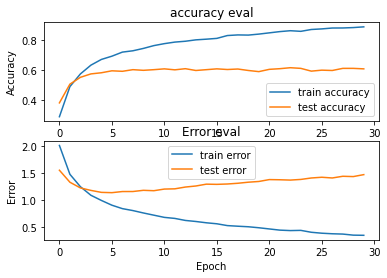

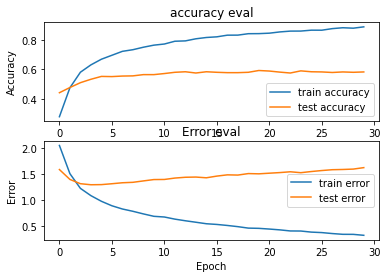

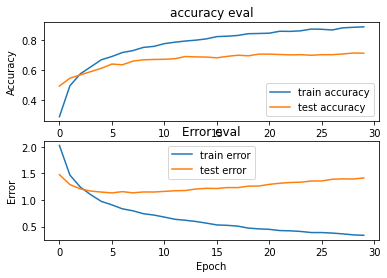

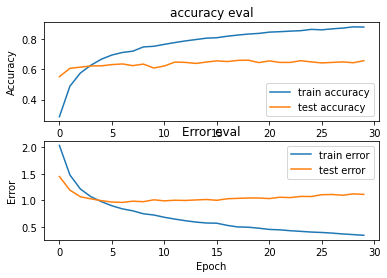

In [11]:

plot_history(model_history_array[0])
plot_history(model_history_array[1])
plot_history(model_history_array[2])
plot_history(model_history_array[3])